In [ ]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 2 (delta 0), pack-reused 758 (from 1)
Receiving objects: 100% (762/762), 105.85 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
import warnings
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
import sys
sys.path.append("/content/fashion-mnist")
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 182ms/step - kl_loss: 4.6120 - loss: 387.3902 - reconstruction_loss: 382.7784
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 180ms/step - kl_loss: 7.4801 - loss: 284.7029 - reconstruction_loss: 277.2229
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 180ms/step - kl_loss: 6.5582 - loss: 272.3732 - reconstruction_loss: 265.8149
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 188ms/step - kl_loss: 6.4235 - loss: 270.1388 - reconstruction_loss: 263.7153
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 182ms/step - kl_loss: 6.4139 - loss: 268.2567 - reconstruction_loss: 261.8427
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 178ms/step - kl_loss: 6.4268 - loss: 267.0205 - reconstruction_loss: 260.5938
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 177ms/step - kl_loss: 6.3925 - loss: 266.2190 - reconstruction_loss: 259.8265
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 181ms/step - kl_loss: 6.4135 - loss: 264.8377 - reconstruction_loss: 258.4242
Epoch 9/10
469/469

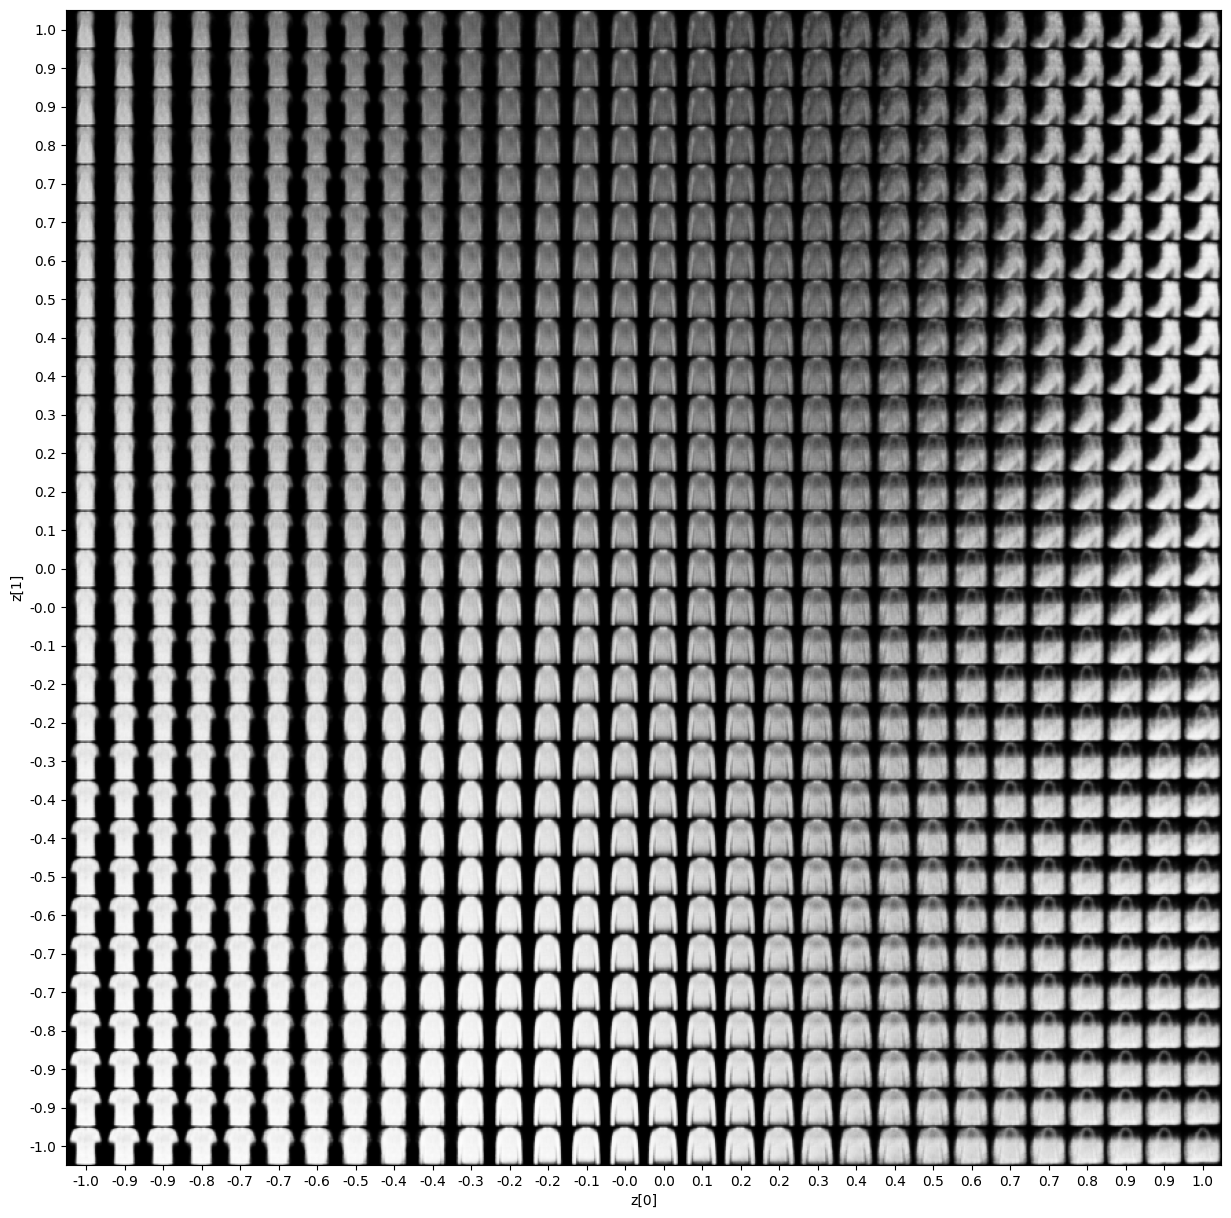

In [ ]:
# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Reshape the data to (28, 28, 1)
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

# Define the VAE model
latent_dim = 2

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# Create the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(X_train, epochs=10, batch_size=128)

# Generate some images
def plot_latent_space(vae, n=30, figsize=15):
  # display a n*n 2D manifold of digits
  digit_size = 28
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = vae.decoder.predict(z_sample)
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[
              i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size,
          ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

plot_latent_space(vae)


In [10]:
train_images2 = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
train_images2 = (train_images2 - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset2 = tf.data.Dataset.from_tensor_slices(train_images2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

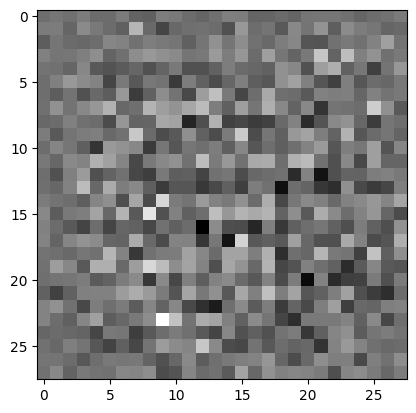

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00259532]], shape=(1, 1), dtype=float32)


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('2image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

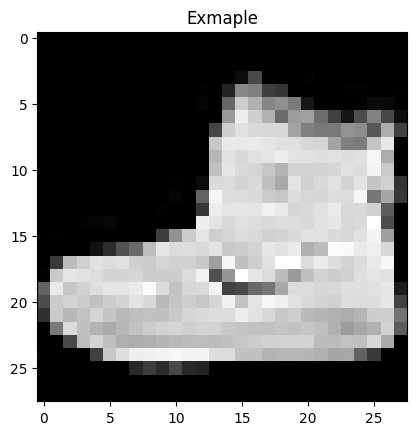

In [20]:
plt.imshow(train_images2[0], cmap='gray')
plt.title(f"Exmaple")
plt.show()

In [ ]:
train(train_dataset2, EPOCHS)